In [1]:
%matplotlib inline

import os, subprocess
from matplotlib import pyplot as plt
import nrrd
import numpy as np
import pandas as pd
from probemapper.io import load_nifti, save_nifti
from probemapper.skeletonization import skeletonize, fit_with_spline

In [2]:
rootdir = "/bucket/ReiterU/DBS/data/20220518_P186_laqueus_DiI_L-A2/"
resultdir = os.path.join(rootdir, "analysis")
if not os.path.exists(resultdir):
    subprocess.run(["ssh", "deigo", "mkdir", resultdir])

In [3]:
cwd = os.path.basename(os.getcwd())
tmpdir = os.path.join("/flash/ReiterU/tmp/", cwd, f"skeleton")
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)

### Load segmented image

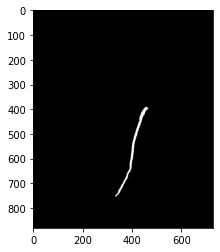

In [4]:
vol, _ = nrrd.read(os.path.join(rootdir, "analysis/slicer_593BP/Segmentation.seg.nrrd"))
vol = np.swapaxes(vol, 0, 2)
plt.imshow(vol.max(axis=2), cmap="gray")

In [5]:
coords = skeletonize(vol, um_per_voxel=5)

1


In [12]:
fitted, dist, num_channels = fit_with_spline(coords, 10, extrapolate_channels=100)
print(dist)
print(num_channels)

1926.697949843348
192


<IPython.core.display.Javascript object>


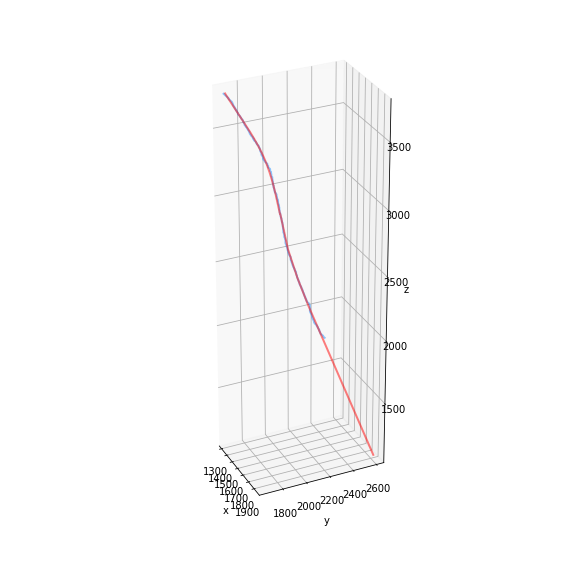

In [13]:
%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(coords[2], coords[1], coords[0], lw =2, c='Dodgerblue', alpha=0.5)
ax.plot(fitted[2], fitted[1], fitted[0], lw =2, c='red', alpha=0.5)
ax.set_box_aspect((np.ptp(coords[2]), np.ptp(coords[1]), np.ptp(coords[0])))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

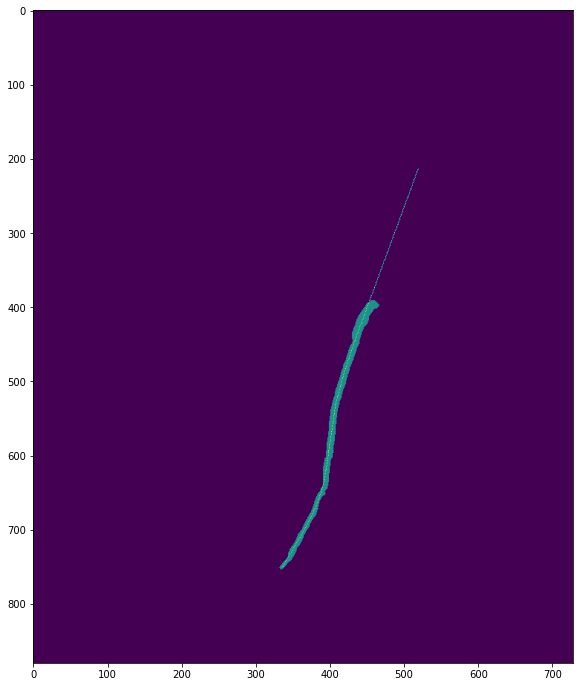

In [14]:
%matplotlib inline

tmp = np.array(vol)
for e in fitted.T:
    idx = (e/5).astype("int")
    tmp[idx[0], idx[1], idx[2]] = 2
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(tmp.max(axis=2))
plt.show()

In [15]:
df = pd.DataFrame()
df["X"] = fitted[2]
df["Y"] = fitted[1]
df["Z"] = fitted[0]
df["X_org"] = fitted[2]
df["Y_org"] = fitted[1]
df["Z_org"] = fitted[0]
df["channel"] = np.arange(-100, num_channels)

In [16]:
df.to_csv(os.path.join(tmpdir, "channel_skeleton.csv"), index=False)

In [17]:
subprocess.run(["scp", "-r", tmpdir, f"deigo:{resultdir}"])

CompletedProcess(args=['scp', '-r', '/flash/ReiterU/tmp/P186/skeleton', 'deigo:/bucket/ReiterU/DBS/data/20220518_P186_laqueus_DiI_L-A2/analysis'], returncode=0)